In [1]:
#load of import
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
%matplotlib inline  
from IPython.display import HTML

In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

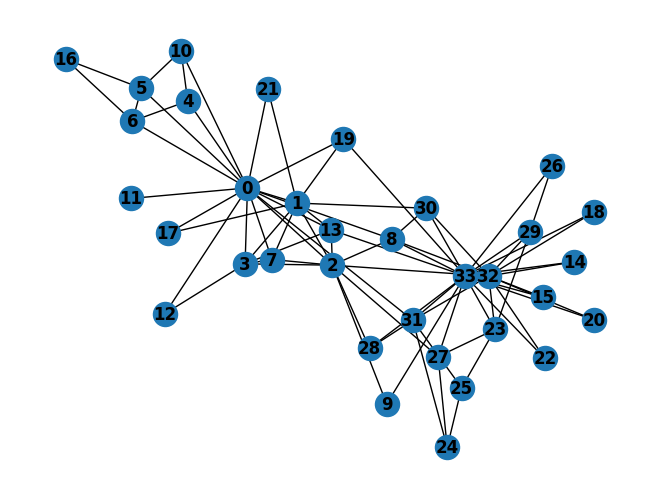

We have 34 nodes.
We have 78 edges.


In [3]:
import networkx as nx
import numpy as np

# load graph from networkx library
G = nx.karate_club_graph()

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

## Deep Walk

In [34]:
from karateclub import DeepWalk

model = DeepWalk(walk_number=10, walk_length=80, dimensions=124)


TypeError: __init__() got multiple values for argument 'walk_number'

## From Networkx to Torch Geometric

In [6]:
from torch_geometric.utils.convert import from_networkx

In [12]:
data = from_networkx(G)
data

Data(edge_index=[2, 156], club=[34], weight=[156], name='Zachary's Karate Club', num_nodes=34)

## Construct SGN model

In [5]:
from torch_geometric.nn import SGConv

In [15]:
SGC_model = SGConv(in_channels= data.num_nodes, # Number of features
                   out_channels= 2, # Dimension of embedding
                   K = 1, cached =True)

In [16]:
" **************** GET EMBEDDING  ********************"
print(" Shape of the original data: ", data.x.shape)
print(" Shape of the embedding data: ", SGC_model(data.x,data.edge_index).shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
" **************** GET EMBEDDING  ********************"
print(" Shape of the original data: ", data.x.shape)
print(" Shape of the embedding data: ", SGC_model(data.x,data.edge_index).shape)


" **************** CONSTRUCT THE MODEL FOR CLASSIFICATION  ********************"
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   K = 1, cached =True)

    def forward(self):
        x = self.conv1(data.x,  data.edge_index) #Applying convolution to data
        
        # computation of log softmax
        return F.log_softmax(x, dim=1)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SGC_model, data = SGCNet().to(device), data.to(device)
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2, weight_decay=0.005)

# What are the learning parameters:
for i, parameter in SGC_model.named_parameters():
    print(" Parameter {}".format(i))
    print("Shape: ",parameter.shape)
    
    
" **************** TRAIN FUNCTION ********************"
def train():
    SGC_model.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = SGC_model() # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses
    
    
" **************** TEST FUNCTION ********************"
def test():
    SGC_model.eval() # Set the model.training to be False
    logits = SGC_model() # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs



" **************** PUTTING IT ALL TOGETHER ********************"
best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))